### Time-series Forcasting involves the following tasks:

Step 1: Quick Overview of the Data Structure

Step 2: Prepare Dataset (Training, Validation, and Test Data)

Step 3: Discover and Visualize the Data

Step 4: Data Preprocessing

Step 5: Model Selection and Training

Step 6: Evalute Models and Feature Importance on the Test Data

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import re

%matplotlib inline 

import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from collections import Counter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Import the dataset 

In [2]:
test = pd.read_csv('data/ps6_test.csv')
df=pd.read_csv('data/ps6_trainvalid.csv')

### Step 1: Quick Overview of the Data Structure

Check variable types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45013 entries, 0 to 45012
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45013 non-null  object 
 1   temperature     45010 non-null  float64
 2   humidity        44861 non-null  float64
 3   pressure        44761 non-null  float64
 4   weather         45012 non-null  object 
 5   wind_direction  45012 non-null  float64
 6   wind_speed      45012 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


This study will conduct the time-series forcasting in hously predictions as the input of data show the variables change for each hour. 

In [4]:
df

,datetime,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,mist,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,sky is clear,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,sky is clear,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,sky is clear,0.0,0.0
...,...,...,...,...,...,...,...
45008,2017-11-19 20:00:00,295.440000,17.0,1017.0,sky is clear,345.0,1.0
45009,2017-11-19 21:00:00,296.020000,16.0,1016.0,sky is clear,345.0,1.0
45010,2017-11-19 22:00:00,296.510000,17.0,1015.0,sky is clear,345.0,1.0
45011,2017-11-19 23:00:00,297.090000,17.0,1014.0,sky is clear,324.0,0.0


Since there are only around 400 data points with missing values, I decided to drop these data points for the model training process. 

In [5]:
df=df.dropna().reset_index(drop=True)

Print dataset after dropping missing values

In [6]:
df

,datetime,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,2012-10-01 13:00:00,291.870000,88.0,1013.0,mist,0.0,0.0
1,2012-10-01 14:00:00,291.868186,88.0,1013.0,sky is clear,0.0,0.0
2,2012-10-01 15:00:00,291.862844,88.0,1013.0,sky is clear,0.0,0.0
3,2012-10-01 16:00:00,291.857503,88.0,1013.0,sky is clear,0.0,0.0
4,2012-10-01 17:00:00,291.852162,88.0,1013.0,sky is clear,0.0,0.0
...,...,...,...,...,...,...,...
44666,2017-11-19 20:00:00,295.440000,17.0,1017.0,sky is clear,345.0,1.0
44667,2017-11-19 21:00:00,296.020000,16.0,1016.0,sky is clear,345.0,1.0
44668,2017-11-19 22:00:00,296.510000,17.0,1015.0,sky is clear,345.0,1.0
44669,2017-11-19 23:00:00,297.090000,17.0,1014.0,sky is clear,324.0,0.0


Snapshot of histogram for numerical variables (Geron, 2019)

From the histograms below, we see that temperature has a normal distribution, while humidity and pressure is right skewed, which means I need to normalize all independent numerical variables in the future steps.

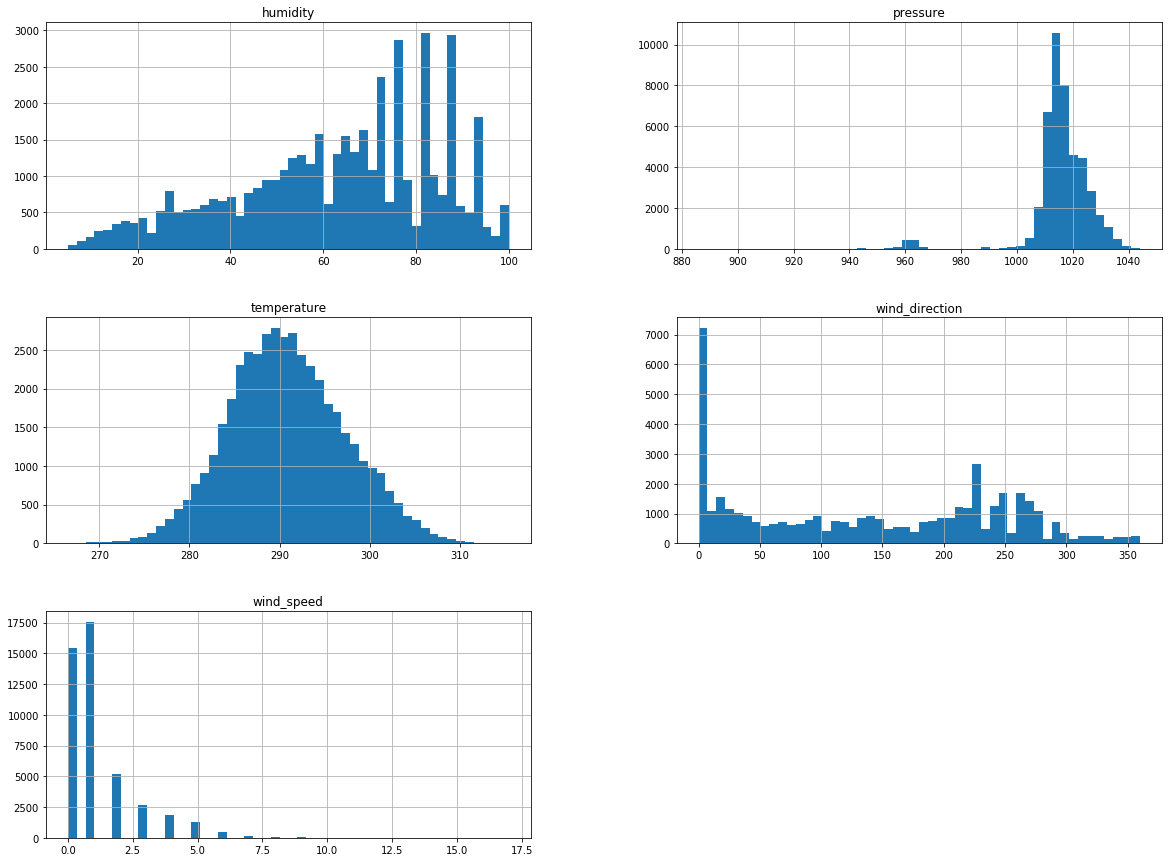

In [7]:
df.hist(bins=50, figsize=(20,15)) 
plt.show()

Descriptive information of the dataset.

Based on the descriptive information, I did not see any outlier values in numerical values. 

In [8]:
df.describe()

,temperature,humidity,pressure,wind_direction,wind_speed
count,44671.000000,44671.000000,44671.000000,44671.000000,44671.000000
mean,290.842504,62.963019,1015.912023,139.570280,1.218710
std,6.466154,21.693978,11.325339,105.438283,1.435231
min,266.503667,5.000000,886.000000,0.000000,0.000000
25%,286.370000,49.000000,1013.000000,29.000000,0.000000
50%,290.535000,66.000000,1016.000000,140.000000,1.000000
75%,295.080000,81.000000,1021.000000,230.000000,2.000000
max,315.470000,100.000000,1044.000000,360.000000,17.000000


Show the distribution by percentage of binary and categorial variables

Based on the distribution of categorical variables, we see that around 57.7% of weather is "sky is clear", while the entire feature is mixed with clear, cloudy, rain and heavy rain categories of weathers.


In [9]:
def show_cat_distribution(df,x):
    return print(df[x].value_counts()/len(df))

categorical_features=['weather']
for x in categorical_features:
    show_cat_distribution(df,x)
    print('\n')

sky is clear                    0.576884
haze                            0.077970
mist                            0.065770
broken clouds                   0.056636
overcast clouds                 0.054017
scattered clouds                0.049898
light rain                      0.043563
few clouds                      0.038660
fog                             0.012491
moderate rain                   0.010768
smoke                           0.004522
heavy intensity rain            0.002843
light intensity drizzle         0.002283
dust                            0.001410
proximity thunderstorm          0.000560
very heavy rain                 0.000448
thunderstorm                    0.000381
thunderstorm with light rain    0.000291
shower rain                     0.000179
drizzle                         0.000112
proximity shower rain           0.000090
light intensity shower rain     0.000067
squalls                         0.000067
thunderstorm with rain          0.000045
thunderstorm wit

Encoding weather to ordinal values based on four categories (clear =0, cloudy = 1, rainy = 2, heavy rain = 3)

In [10]:
weathers=[]
for x in range(len(df.weather)):
    if df.weather[x]=="sky is clear":
        weathers.append(0)
    elif df.weather[x]=="haze" or df.weather[x]=="mist" or df.weather[x]=="broken clouds" or df.weather[x]=="overcast clouds" or df.weather[x]=="scattered clouds" or df.weather[x]=="few clouds" or df.weather[x]=="fog" or df.weather[x]=="smoke" or df.weather[x]=="dust":
        weathers.append(1)
    elif df.weather[x]=="light rain" or df.weather[x]=="moderate rain" or df.weather[x]=="light intensity drizzle" or df.weather[x]=="drizzle" or df.weather[x]=="light intensity shower rain":
        weathers.append(2)
    elif df.weather[x]=="heavy intensity rain" or df.weather[x]=="proximity thunderstorm" or df.weather[x]=="very heavy rain" or df.weather[x]=="thunderstorm" or df.weather[x]=="thunderstorm with light rain" or df.weather[x]=="shower rain" or df.weather[x]=="squalls" or df.weather[x]=="thunderstorm with rain" or df.weather[x]=="thunderstorm with heavy rain" or df.weather[x]=="proximity shower rain":
        weathers.append(3)
    else:
        weathers.append(99)
        print(df.weather[x])

Replace the original weather with the numerical values

In [11]:
df['weather']=weathers

Show the updated table

In [12]:
df.head()

,datetime,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,2012-10-01 13:00:00,291.870000,88.0,1013.0,1,0.0,0.0
1,2012-10-01 14:00:00,291.868186,88.0,1013.0,0,0.0,0.0
2,2012-10-01 15:00:00,291.862844,88.0,1013.0,0,0.0,0.0
3,2012-10-01 16:00:00,291.857503,88.0,1013.0,0,0.0,0.0
4,2012-10-01 17:00:00,291.852162,88.0,1013.0,0,0.0,0.0


Print the percentage distribution of weather in the updated table 

In [13]:
categorical_features=['weather']
for x in categorical_features:
    show_cat_distribution(df,x)
    print('\n')

0    0.576884
1    0.361375
2    0.056793
3    0.004947
Name: weather, dtype: float64




### Step 3: Discover and Visualize the Data

Prepare a copy of the training data in case we need to retrieve the original training data (Geron, 2019)

In [14]:
df_copy=df
df_copy=df.copy()

Check the correlation between all numerial variables (Geron, 2019)

In [15]:
corr_matrix =df.corr()
corr_matrix

,temperature,humidity,pressure,weather,wind_direction,wind_speed
temperature,1.000000,-0.372790,-0.218664,-0.178626,0.346981,0.299287
humidity,-0.372790,1.000000,-0.018018,0.402390,-0.098036,-0.160967
pressure,-0.218664,-0.018018,1.000000,-0.023110,-0.088163,-0.071152
weather,-0.178626,0.402390,-0.023110,1.000000,-0.050210,0.007478
wind_direction,0.346981,-0.098036,-0.088163,-0.050210,1.000000,0.406863
wind_speed,0.299287,-0.160967,-0.071152,0.007478,0.406863,1.000000


Plot the correlation between all numerial variables (Geron, 2019)

From graphs below, we see that humidity and temperature are somewhat related, which is intuitive because higher humidity is likely to reduce the temperature, which leads to a negative relationship between the two. Additionally, the ordinal feature weather created in the last step is positively correlated with the humidity because the higher value for the weather, the rainier the day is, and hence more likely to have a higher humidity.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dbccb10>,
      dtype=object)

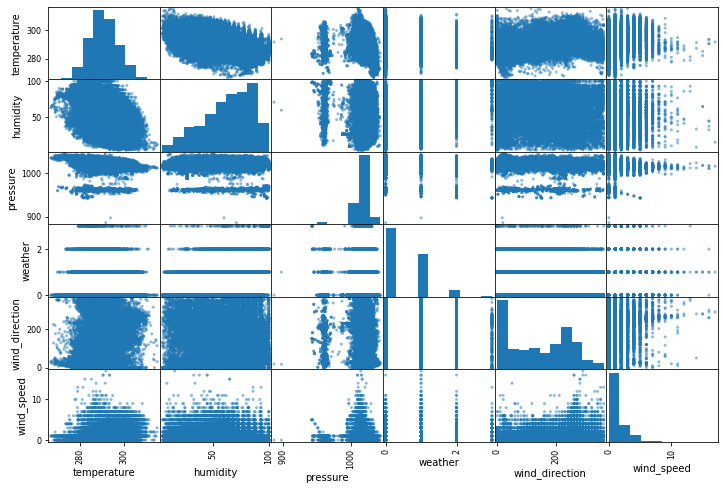

In [16]:
from pandas.plotting import scatter_matrix

scatter_matrix(df,figsize=(12,8))

Separate the date time variables from the dataset for the future time-series modeling (TensorFlow Documentation, 2021)

In [17]:
date_time = pd.to_datetime(df.pop('datetime'), format='%Y-%m-%d %H:%M:%S')

Print the dataset after the separation. 

In [18]:
df.head()

,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,291.870000,88.0,1013.0,1,0.0,0.0
1,291.868186,88.0,1013.0,0,0.0,0.0
2,291.862844,88.0,1013.0,0,0.0,0.0
3,291.857503,88.0,1013.0,0,0.0,0.0
4,291.852162,88.0,1013.0,0,0.0,0.0


Inspired by TensorFlow Documentation (2021), I plotted five numerical variables in time-series graphs. The first graph illustrates how these variables change in years, while the second graph illustrates how they vary in within 20 days (480 hours). 

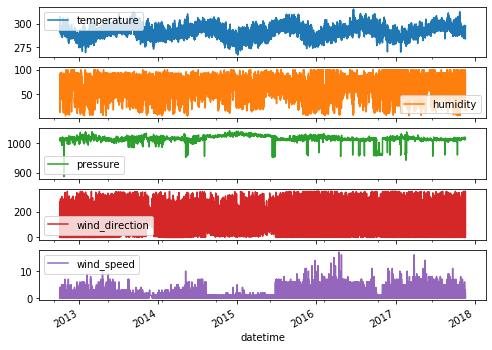

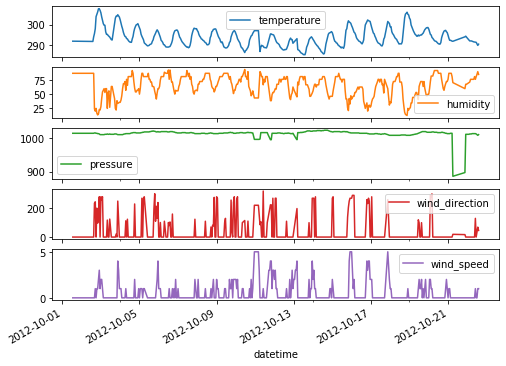

In [19]:
plot_cols = ['temperature', 'humidity', 'pressure','wind_direction','wind_speed']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

#### Feature Engineering 

Among all six numerical features in this prediction task, weather has been converted from a categorical variable to an ordinal variable by reducing 25 subcategories to four parental categories. 

##### Wind

Visualize wind speed and wind direction (TensorFlow Documentation, 2021)

Text(0, 0.5, 'wind_speed')

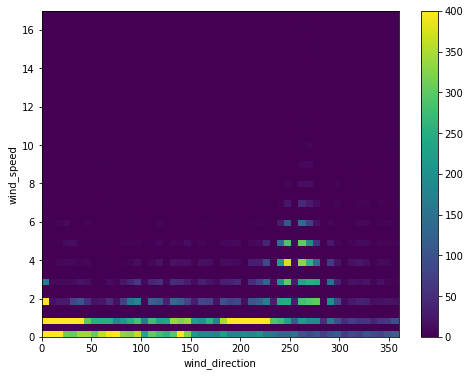

In [20]:
plt.hist2d(df['wind_direction'], df['wind_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('wind_direction')
plt.ylabel('wind_speed')

Convert wind direction and speed to a wind vector (TensorFlow Documentation, 2021)

In [21]:
wv = df.pop('wind_speed')
max_wv = 17.0

# Convert to radians.
wd_rad = df.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Visualize wind vectors (TensorFlow Documentation, 2021)

(-11.0, 13.0, -15.974774553360445, 10.724622203665692)

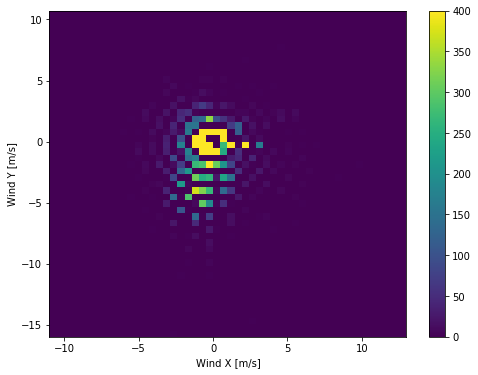

In [22]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

##### Time 

Map date and time information from string format to seconds (TensorFlow Documentation, 2021)

In [23]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Add the periodicity to date time feature (TensorFlow Documentation, 2021)

In [24]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Plot the cyclicity of date time feature (TensorFlow Documentation, 2021)

Text(0.5, 1.0, 'Time of day signal')

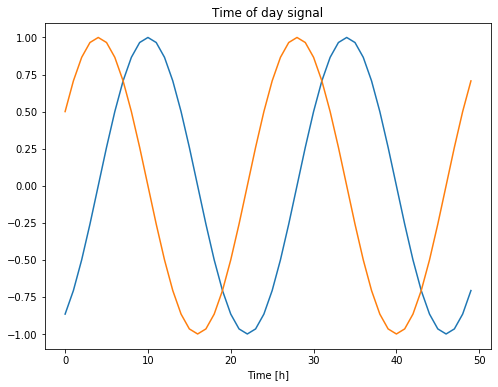

In [25]:
plt.plot(np.array(df['Day sin'])[:50])
plt.plot(np.array(df['Day cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

After the feature engineering step, I created another correlation matrix to show the variation in coefficients and the relationships between all updated features and future temperatures.

In [26]:
corr_matrix =df.corr()
corr_matrix

,temperature,humidity,pressure,weather,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
temperature,1.000000,-0.372790,-0.218664,-0.178626,-0.233013,-0.309827,-0.285571,-0.331647,0.543781,0.043346,-0.267752,-0.528149
humidity,-0.372790,1.000000,-0.018018,0.402390,-0.072256,0.087218,0.005001,0.192055,-0.473780,-0.089005,0.023747,-0.157173
pressure,-0.218664,-0.018018,1.000000,-0.023110,0.062451,0.075285,0.050344,0.081527,-0.027279,0.043996,0.152296,0.183336
weather,-0.178626,0.402390,-0.023110,1.000000,-0.055722,0.076249,-0.030093,0.097885,-0.116068,0.098112,0.092991,0.036807
Wx,-0.233013,-0.072256,0.062451,-0.055722,1.000000,0.206204,0.648319,0.194016,-0.196480,0.016964,0.018189,0.212117
Wy,-0.309827,0.087218,0.075285,0.076249,0.206204,1.000000,0.145271,0.706302,-0.369165,0.114447,-0.029294,0.151469
max Wx,-0.285571,0.005001,0.050344,-0.030093,0.648319,0.145271,1.000000,0.203722,-0.270607,0.050518,0.070454,0.269056
max Wy,-0.331647,0.192055,0.081527,0.097885,0.194016,0.706302,0.203722,1.000000,-0.454613,0.145976,-0.018262,0.069786
Day sin,0.543781,-0.473780,-0.027279,-0.116068,-0.196480,-0.369165,-0.270607,-0.454613,1.000000,-0.000441,-0.001095,-0.000706
Day cos,0.043346,-0.089005,0.043996,0.098112,0.016964,0.114447,0.050518,0.145976,-0.000441,1.000000,0.000402,-0.000967


### Step 2: Prepare Dataset (Training, Validation, and Test Data)

Traing, validation and test data have been split based on the 8:1:1 ratio. Test size of 0.1 is selected because I want to save more data for training and validating models, while 10% of the entire dataset is 4,000+ data points, which should be sufficient for testing the results (TensorFlow Documentation, 2021)


In [27]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Verify the percentage distribution of training and test data based on 'weather' categories.

According to the percentage distribution of training and test datasets, we are confident that our stratified sampling has similar distribution with our original dataset

In [28]:
categorical_features=['weather']
for x in categorical_features:
    show_cat_distribution(train_df,x)
    print('\n')

for x in categorical_features:
    show_cat_distribution(val_df,x)
    print('\n')
    
for x in categorical_features:
    show_cat_distribution(test_df,x)
    print('\n')

0    0.616493
1    0.318614
2    0.060024
3    0.004869
Name: weather, dtype: float64


1    0.486009
0    0.435639
2    0.071860
3    0.006492
Name: weather, dtype: float64


1    0.578782
0    0.401298
2    0.015891
3    0.004029
Name: weather, dtype: float64




### Step 4: Data Preprocessing

Since humidity and pressure of numerical variables are right skewed distributions, I performed a normalization to all these variables because neural network models would favor a standardized input for a more stable model training.

Normalizing numerical variables (TensorFlow Documentatoin, 2021)

In [29]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Illustrating the normalized result, we see there is no outlier in the dataset (TensorFlow Documentatoin, 2021)

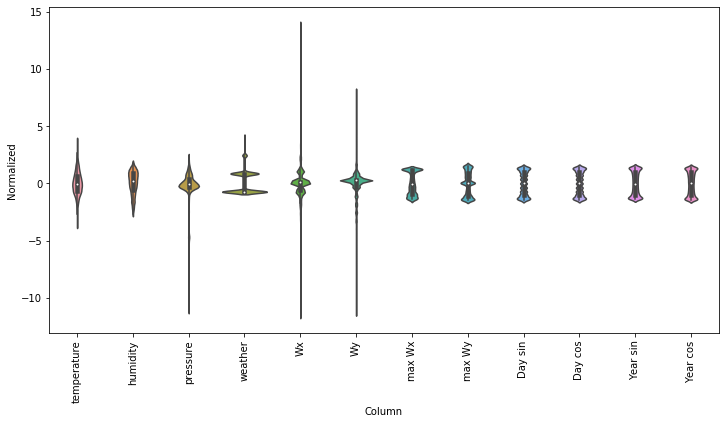

In [30]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

##### Data windowing

Defining a function Window Generator, I was able to separate data points into input and offset data (TensorFlow Documentation, 2021)

In [31]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])
w1

I defined a window generate that will use the weather data from the last six hours to predict the temperature for the next an hour (TensorFlow Documentation, 2021)

In [32]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['temperature'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

##### Split Window

Define a split window function to split the time-series data by input and offest for future usage (TensorFlow Documentation, 2021)

In [33]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


With the window size defined, I split window by 6:1, where the first six time steps will be used as input and the last time step will be used as label (TensorFlow Documentation, 2021)

In [34]:
WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 12)
Inputs shape: (3, 6, 12)
labels shape: (3, 1, 1)


##### Plot

Plot a sample of the split window (TensorFlow Documentation, 2021)

In [35]:
w2.example = example_inputs, example_labels

Define a function to plaot the split window (TensorFlow Documentation, 2021)

In [36]:
def plot(self, model=None, plot_col='temperature', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
              label_col_index = plot_col_index

        if label_col_index is None:
              continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

    if n == 0:
          plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Plotting the split window, we can visualize how to use the last six time steps (six hours) to predict the temperature for the next time step (next 1 hour) (TensorFlow Documentation, 2021)

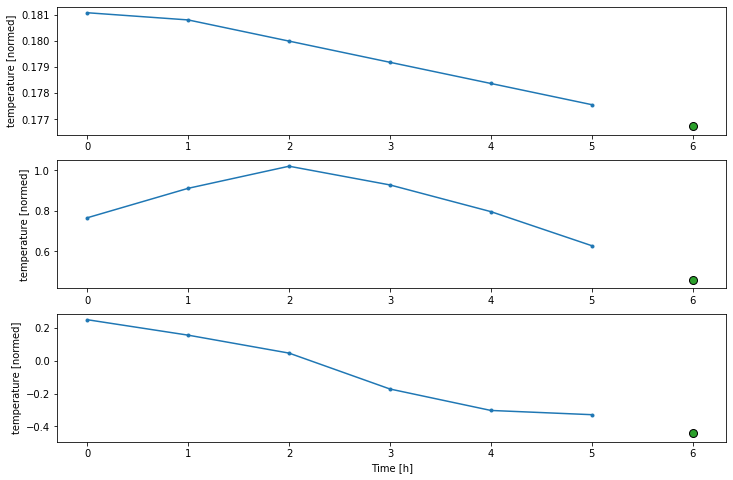

In [37]:
w2.plot()

##### Data Format Converting 

I converted all input and labels into format that can be used by the TensorFlow package. To achieve this, I defined a make_dataset function will convert the dataset based on the rule of window generators (TensorFlow Documentation, 2021)

In [38]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

Apply the make_dataset function to training, validation and test datasets respectively (TensorFlow Documentation, 2021)

In [39]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
        return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Print the shape of training datasets for both input and labels (TensorFlow Documentation, 2021)

In [40]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Print the shape of training datasets in the example data for input and labels by batch, time, and features (TensorFlow Documentation, 2021)

In [41]:
for example_inputs, example_labels in w2.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)


### Step 5: Model Selection and Training

TensorFlow Documentation: https://www.tensorflow.org/tutorials/structured_data/time_series

#### Preliminary comparision of different models

This project applies five single timestep models, including baseline model, linear model, denes model, CNN model, and RNN model to predict the temperature for the next timestep. The single step models are the basic that can only predict a single value at a time based on the current feature values. MAE will be used for comparing the model performance between the five single timestep models. The lower the MAE score indicates the better the model does at predicting the next timestep for the future temperature. 

This model selection step does not separate the measurement for validation and test data in different round because their measurements have been directly written into the model compile and evaluation process in using TensorFlow for time-series analysis. 

1. Baseline Model

This baseline model could predict 1 hour in the future based on the current values of all features (TensorFlow Documentation, 2021)

In [42]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

Build the baseline model (TensorFlow Documentation, 2021)

In [43]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

Initiate and evaluate the baseline model (TensowFlow Documentation, 2021)

In [44]:
baseline = Baseline(label_index=column_indices['temperature'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

140/140 [==============================] - 0s 2ms/step - loss: 0.0358 - mean_absolute_error: 0.1208


Using plot function from WindowGenerator, I plotted a longer period of time (24hrs) to show the consecutive inputs and labels for a specific time (TensorFlow Documentation, 2021)

In [45]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

The following plot of the baseline model indicates that all the predicted temperature is a one-hour shift in the current value, which means the baseline model predicts all the future value of the next hour would be the same as the last hour (TensorFlow Documentation, 2021)

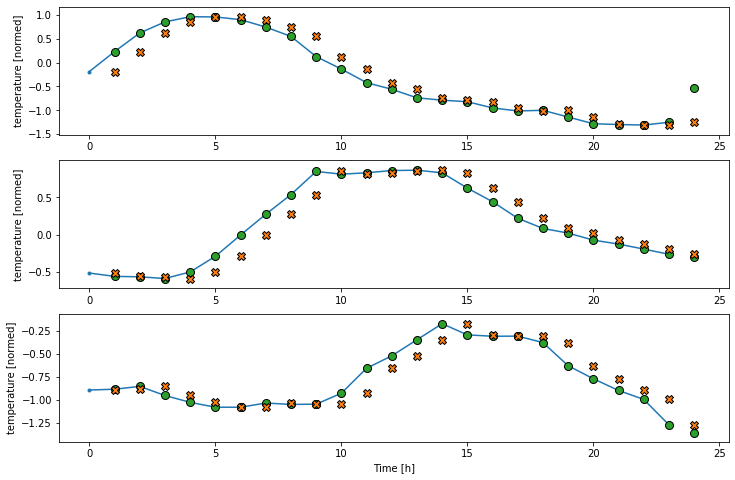

In [46]:
wide_window.plot(baseline)

2. Linear Model

I designed a linear model by having no activation layer in the sequential TensorFlow architecture, which will predict the output through linear transformation of the input (TensorFlow Documentation, 2021)

In [47]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

I compiled a function to train linear models for multiple runs, evaluating them with MSE scores as well as setting the maximum epochs to 20 (TensorFlow Documentation, 2021)

In [48]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Train and evaluate the linear model (TensorFlow Documentation, 2021)

In [49]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.4892 - mean_absolute_error: 0.4718 - val_loss: 0.0477 - val_mean_absolute_error: 0.1644
Epoch 2/20
1117/1117 [==============================] - 2s 1ms/step - loss: 0.0504 - mean_absolute_error: 0.1576 - val_loss: 0.0256 - val_mean_absolute_error: 0.1147
Epoch 3/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0446 - mean_absolute_error: 0.1411 - val_loss: 0.0252 - val_mean_absolute_error: 0.1128
Epoch 4/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0445 - mean_absolute_error: 0.1406 - val_loss: 0.0255 - val_mean_absolute_error: 0.1141
Epoch 5/20
140/140 [==============================] - 0s 1ms/step - loss: 0.0254 - mean_absolute_error: 0.1135


Using plot function from WindowGenerator, I plotted a longer period of time (24hrs) to show the consecutive inputs and labels for a specific time (TensorFlow Documentation, 2021)

In [50]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

Plot the predicted value for the next hour using the linear model (TensorFlow Documentation, 2021)

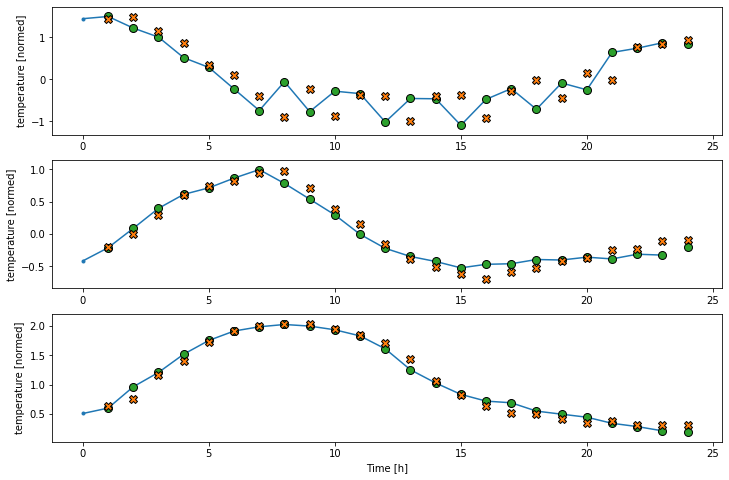

In [51]:
wide_window.plot(linear)

Output the weights of each feature for interpretation (TensorFlow Documentation, 2021).

One benefit of applying the linear model is that it can show the output of the weights of each feature for more detailed interpretation of feature important and relevancy. It is intuitive to think that historical temperature would be the dominant feature in predicting the temperature for the next hour, which is also supported by the below that historical temperature gets a coefficient close to 1.0 in the feature important metric. Periodicity in daytime has been the second dominant feature that is positively associated with the temperature prediction, while seasonality in year is moderately negatively associated with the temperature prediction. 

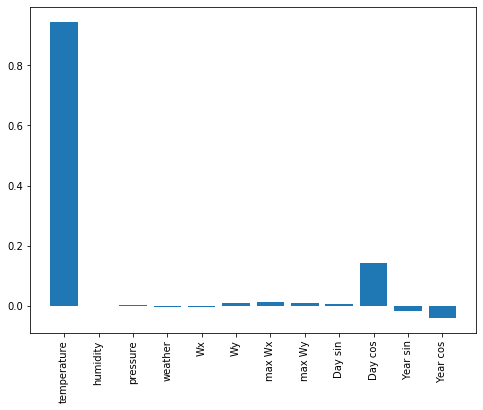

In [52]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

3. Dense Model 

Building upon the simple linear model, the dense model adds multiple dense layers between the input and the output, further sophisticate the linear transformation between the two group of variables. Similar to the baseline and linear models, dense also “handle each timestep independently” (TensorFlow Documentation, 2021), which means there is no interaction between the prediction at different timestep in the dense model. 

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0590 - mean_absolute_error: 0.1611 - val_loss: 0.0287 - val_mean_absolute_error: 0.1184
Epoch 2/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0412 - mean_absolute_error: 0.1336 - val_loss: 0.0242 - val_mean_absolute_error: 0.1087
Epoch 3/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0394 - mean_absolute_error: 0.1298 - val_loss: 0.0199 - val_mean_absolute_error: 0.0959
Epoch 4/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0383 - mean_absolute_error: 0.1272 - val_loss: 0.0187 - val_mean_absolute_error: 0.0912
Epoch 5/20
1117/1117 [==============================] - 2s 2ms/step - loss: 0.0377 - mean_absolute_error: 0.1256 - val_loss: 0.0205 - val_mean_absolute_error: 0.0994
Epoch 6/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0924


The dense model take multiple time steps (12hrs) as input to product a single output (1hr) (TensorFlow Documentation, 2021)

Therefore, a window with the specified input and output size (12 vs. 1) has been specified by using the window generator function. 

In [54]:
CONV_WIDTH = 12
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['temperature'])

conv_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['temperature']

Plot the graph of the CNN model (TensorFlow Documentation, 2021)

Text(0.5, 1.0, 'Given 12h as input, predict 1h into the future.')

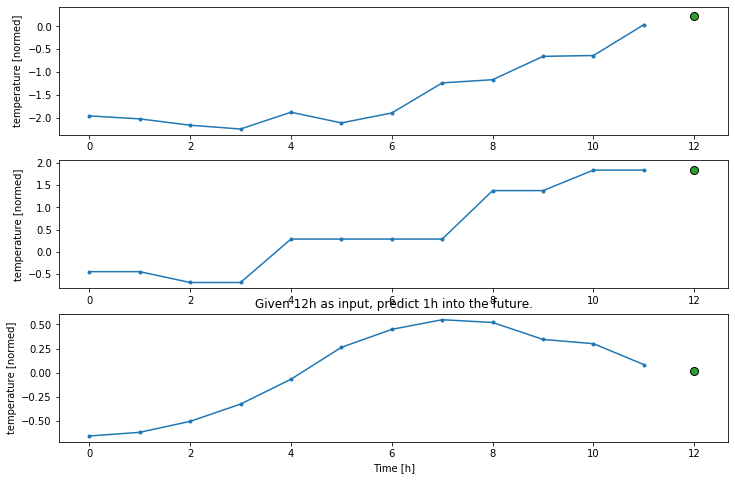

In [55]:
conv_window.plot()
plt.title("Given 12h as input, predict 1h into the future.")

4. Convolution neural network (CNN)

Different from the previous linear model and similar as the dense model, CNN also takes multiple timesteps as input for predicting the next timestep using a convolutional layer (TensorFlow Documentation, 2021)

In [56]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Train and evaluate the CNN model based on the mean absolute error (TensorFlow Documentation, 2021)

In [57]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

140/140 [==============================] - 0s 1ms/step - loss: 0.0266 - mean_absolute_error: 0.1160


Generating a window that matches the length of label and prediction (TensorFlow Documentation, 2021)

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['temperature'])

wide_conv_window

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['temperature']

Plot the weather forecast  predicted by CNN based on 12 preceding timesteps (TensorFlow Documentation, 2021)

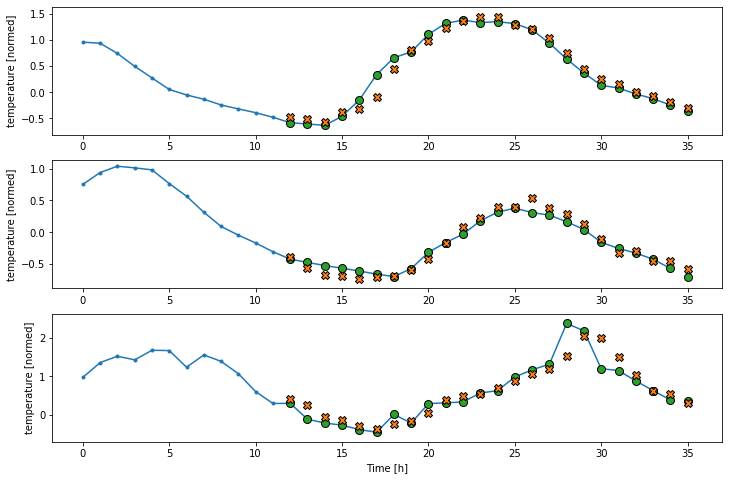

In [59]:
wide_conv_window.plot(conv_model)

5. Recurrent neural network (RNN)

Design a RNN model with Long Short Term Memory (LSTM) layer to prevent losing the information of the initial input (TensorFlow Documentation, 2021)

In [60]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

Train and evaluate the RNN model (TensorFlow Documentation, 2021)

In [61]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

139/139 [==============================] - 0s 2ms/step - loss: 0.0239 - mean_absolute_error: 0.0963


Use plot function from WindowGenerator and plot a longer period of time (24hrs) to show the consecutive inputs and labels for a specific time (TensorFlow Documentation, 2021)

In [62]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temperature']

I also identified the effectiveness of the RNN model from its time-series graph that most of the predicted values are perfectly aligned with their labels, which explained the lower value in its MAE score (TensorFlow Documentation, 2021)

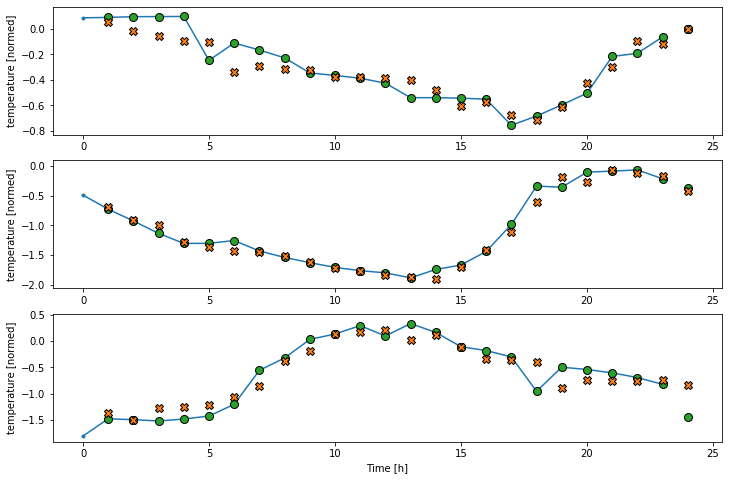

In [63]:
wide_window.plot(lstm_model)

### Step 6: Model Evaluation

Plot the MAE score of each model for both validation and test datasets to compare the model performance (TensorFlow Documentation, 2021)

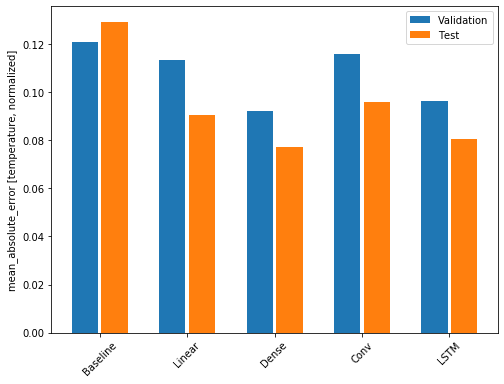

In [64]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [temperature, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Print the MAE of each model (TensorFlow Documentation, 2021)

In [65]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1292
Linear      : 0.0906
Dense       : 0.0773
Conv        : 0.0960
LSTM        : 0.0805
